It seems was have both patients (Diagnosis = 1) and controls (Diagnosis = 0) in this dataset. Let's quickly look how many we have of each

In [95]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
import os
import shutil

In [98]:
# Load and view simulated tutorial data
# The data needs to be in the same directory as your notebook

data = pandas.read_csv('finalEBM_input.csv')
data

,Unnamed: 0,RID,Diagnosis,AGE,ADAS11_bl,Average_hippo,Average_meta_tau,ctx_entorhinal_tau,ctx_inferiorparietal_tau,ctx_inferiortemporal_tau,...,Hippocampus_tau,Amygdala_tau,ctx_precuneus_tau,ctx_anteriorcingulate_tau,Average_superiorfrontal_vol,Average_anteriorcingulate_vol,Average_posteriorcingulate_vol,Average_precuneus_vol,Average_inferiorparietal_vol,Average_inferiortemporal_vol
0,0,21,CN,72.6,-0.172429,0.062109,0.134515,-0.011721,-0.175590,0.356465,...,2.382817,-0.093166,-0.597984,0.121476,0.449522,0.301755,0.532955,0.757263,-0.239702,1.704690
1,1,31,CN,77.7,-1.735559,2.046008,-0.392692,0.623041,-0.477772,-0.668344,...,0.428236,0.057401,-0.282911,-0.197098,0.819599,0.170225,0.503228,-0.052603,0.279301,1.286340
2,3,56,MCI,69.6,-1.319766,0.710701,0.456155,1.153732,0.418942,0.147350,...,0.934010,0.272791,0.946754,0.601243,0.502718,2.723248,0.207082,-0.088145,0.967623,1.773868
3,5,59,MCI,70.9,-0.069262,0.581602,0.544075,0.635106,0.399789,0.297354,...,2.263903,0.557123,1.181402,0.491065,1.084545,0.817633,0.672696,0.396530,1.746611,1.869215
4,6,69,MCI,72.9,0.346530,0.370436,1.093217,0.857338,0.732524,0.930174,...,0.191038,1.150125,1.114470,0.874382,-0.376692,-0.057383,0.429549,-0.127077,0.361946,0.004851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,812,6704,MCI,65.3,3.160164,0.470892,-0.188450,-0.323373,0.191931,-0.064490,...,-0.551500,-0.765101,0.653389,0.361317,1.752011,1.306636,0.455020,0.965912,1.024877,1.925646
646,813,6705,MCI,74.9,0.971782,2.098817,1.965910,2.678315,1.139518,1.376567,...,1.049724,2.596439,1.583092,0.237739,-0.001617,1.134429,0.922593,-0.098058,0.080927,-0.253239
647,814,6713,CN,71.1,0.971782,0.521152,-0.249232,-0.260623,0.234837,-0.127469,...,-0.369991,-0.220408,0.645313,0.412271,-0.221338,0.301398,-1.040388,-0.699135,-0.754194,-0.464371
648,815,6721,Dementia,77.9,3.785416,2.874163,-0.762779,-0.695716,-1.116853,-0.748597,...,-1.031006,-0.272775,-1.108548,-0.852030,0.185680,1.569582,-0.350836,0.463439,-0.699300,-0.347036


In [99]:
data.Diagnosis.value_counts()

Diagnosis
CN          390
MCI         196
Dementia     64
Name: count, dtype: int64

In [100]:
# store our biomarker labels as a variable
biomarkers = data.columns[[4,5,7,11,12]]
print(biomarkers)

Index(['ADAS11_bl', 'Average_hippo', 'ctx_entorhinal_tau', 'Hippocampus_tau',
       'Amygdala_tau'],
      dtype='object')


## Plotting input features

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


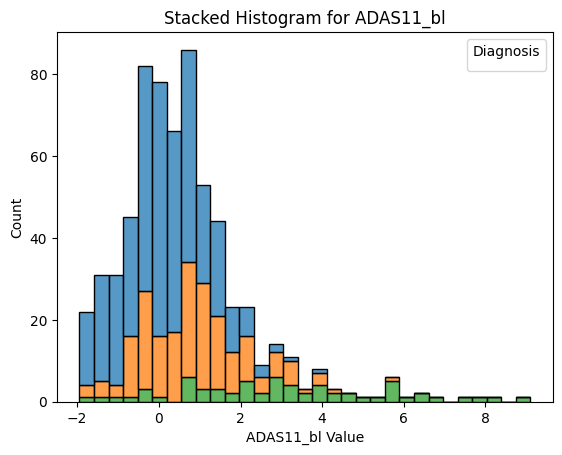

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


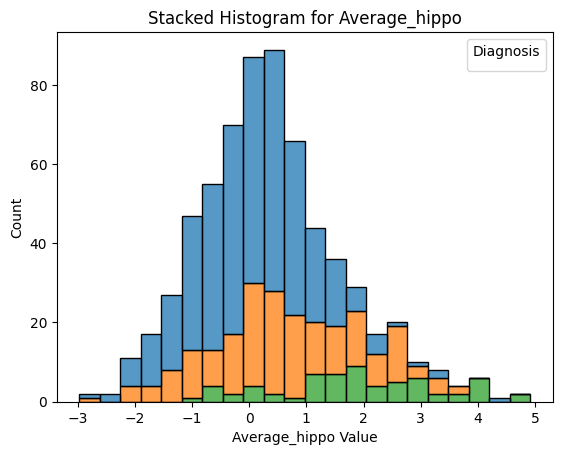

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


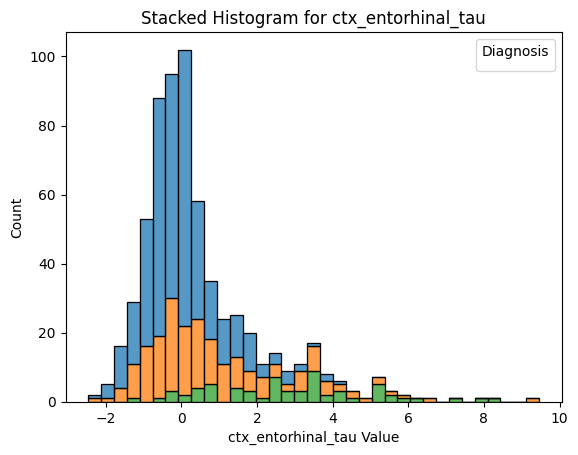

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


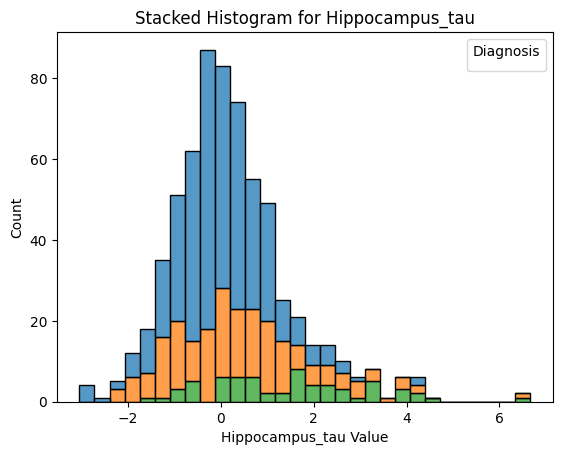

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


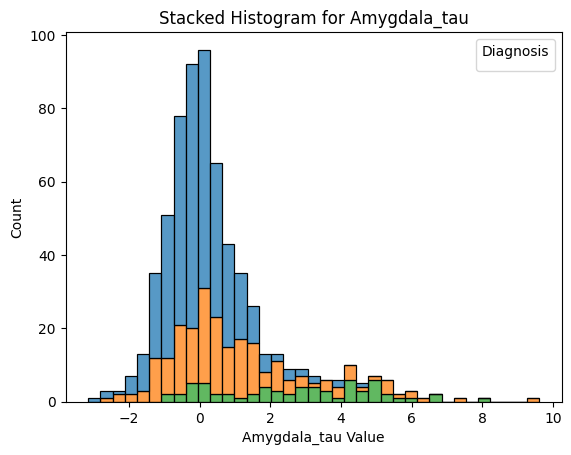

In [101]:
# Plot biomarker histograms check their distributions

for biomarker in biomarkers:
    plt.figure()  # Creates a new figure for each plot
    sns.histplot(data=data, x=biomarker, hue='Diagnosis', multiple='stack')
    plt.title(f'Stacked Histogram for {biomarker}')
    plt.xlabel(f'{biomarker} Value')
    plt.ylabel('Count')
    plt.legend(title='Diagnosis')
    plt.show()

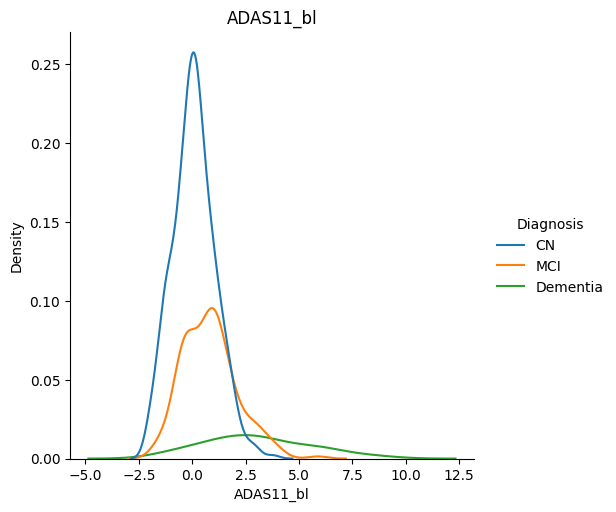

In [102]:
# first a quick look at the patient and control distribution for one of our biomarkers

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='Diagnosis', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

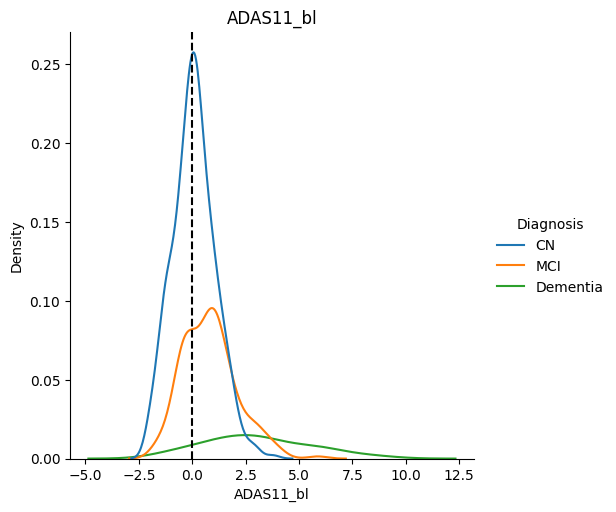

In [8]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='Diagnosis',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

# Prepare SuStaIn inputs

In [115]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers

Z_vals = np.array([[0.4,1.3,2.5],[0.4,1.3,2.5],[0.001,0.8,2],[0.4,1.3,2.5],[0.4,1.3,2.5]])     # Z-scores for each biomarker --> adjust this!
# Order: 'ADAS11_bl', 'Average_hippo', 'ctx_entorhinal_tau', 'Hippocampus_tau', 'Amygdala_tau'

# [0.4,1.3,2.5],[0.4,1.3,2.5],[0.001,0.8,2],[0.4,1.3,2.5],[0.4,1.3,2.5]
Z_max  = np.array([5,5,5,5,5])  # maximum z-score


In [73]:
print(Z_vals)
print(Z_max)

[[4.0e-01 1.3e+00 2.5e+00]
 [4.0e-01 1.3e+00 2.5e+00]
 [1.0e-03 8.0e-01 2.0e+00]
 [4.0e-01 1.3e+00 2.5e+00]
 [4.0e-01 1.3e+00 2.5e+00]]
[5 5 5 5 5]


In [116]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 25
N_S_max = 1
N_iterations_MCMC = int(1e5) # Increase this to 1e5 or 1e6
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

# Run SuStaIn!

In [117]:
# Delete pickle file
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

In [118]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [119]:
   samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -5565.1503347863045


MCMC Iteration: 100%|██████████| 100000/100000 [00:38<00:00, 2575.88it/s]


In [120]:
# Get model output from pickle file
s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# Assess likelihood across MCMC samples
Use to assess the selections of z_vals for each biomarker. Use whichever combination of z_vals maximizes likelihood.

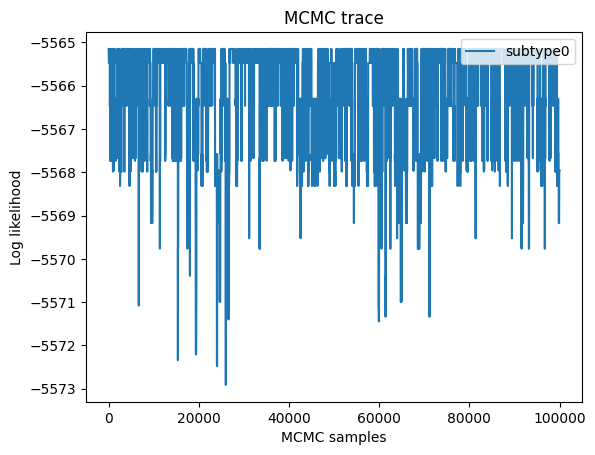

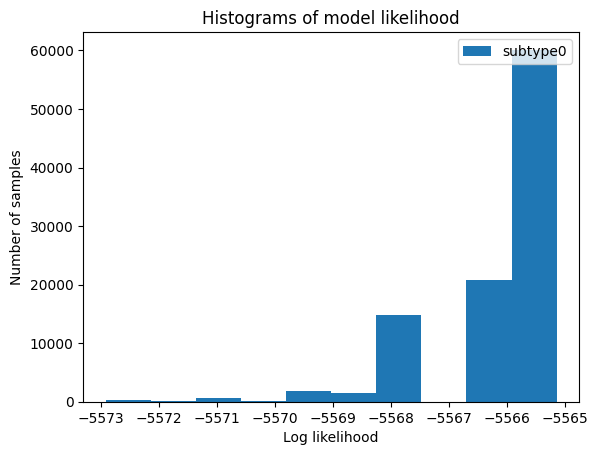

In [121]:
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

# Stage individuals

In [46]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [122]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# We don't need this 
# let's also add the probability for each subject of being each subtype
#for i in range(s):
    #zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

zdata

,Unnamed: 0,RID,Diagnosis,AGE,ADAS11_bl,Average_hippo,Average_meta_tau,ctx_entorhinal_tau,ctx_inferiorparietal_tau,ctx_inferiortemporal_tau,...,Average_superiorfrontal_vol,Average_anteriorcingulate_vol,Average_posteriorcingulate_vol,Average_precuneus_vol,Average_inferiorparietal_vol,Average_inferiortemporal_vol,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,0,21,CN,72.6,-0.172429,0.062109,0.134515,-0.011721,-0.175590,0.356465,...,0.449522,0.301755,0.532955,0.757263,-0.239702,1.704690,0.0,1.0,4.0,0.168784
1,1,31,CN,77.7,-1.735559,2.046008,-0.392692,0.623041,-0.477772,-0.668344,...,0.819599,0.170225,0.503228,-0.052603,0.279301,1.286340,0.0,1.0,0.0,0.160300
2,3,56,MCI,69.6,-1.319766,0.710701,0.456155,1.153732,0.418942,0.147350,...,0.502718,2.723248,0.207082,-0.088145,0.967623,1.773868,0.0,1.0,4.0,0.152872
3,5,59,MCI,70.9,-0.069262,0.581602,0.544075,0.635106,0.399789,0.297354,...,1.084545,0.817633,0.672696,0.396530,1.746611,1.869215,0.0,1.0,5.0,0.199176
4,6,69,MCI,72.9,0.346530,0.370436,1.093217,0.857338,0.732524,0.930174,...,-0.376692,-0.057383,0.429549,-0.127077,0.361946,0.004851,0.0,1.0,5.0,0.163182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,812,6704,MCI,65.3,3.160164,0.470892,-0.188450,-0.323373,0.191931,-0.064490,...,1.752011,1.306636,0.455020,0.965912,1.024877,1.925646,0.0,1.0,2.0,0.203562
646,813,6705,MCI,74.9,0.971782,2.098817,1.965910,2.678315,1.139518,1.376567,...,-0.001617,1.134429,0.922593,-0.098058,0.080927,-0.253239,0.0,1.0,9.0,0.265523
647,814,6713,CN,71.1,0.971782,0.521152,-0.249232,-0.260623,0.234837,-0.127469,...,-0.221338,0.301398,-1.040388,-0.699135,-0.754194,-0.464371,0.0,1.0,1.0,0.204371
648,815,6721,Dementia,77.9,3.785416,2.874163,-0.762779,-0.695716,-1.116853,-0.748597,...,0.185680,1.569582,-0.350836,0.463439,-0.699300,-0.347036,0.0,1.0,4.0,0.221788


In [125]:
# Save zdata to a new file for analysis (GO TO PROCESSING MODEL OUTPUT TO CONTINUE IGNORE ALL FOLLOWING CODE)
zdata.to_csv('zdata.csv')

In [123]:
#zdata.ml_subtype.value_counts()
zdata.ml_stage.value_counts()

ml_stage
0.0     278
1.0      78
6.0      48
5.0      33
2.0      32
4.0      30
7.0      28
3.0      27
8.0      17
13.0     17
14.0     15
9.0      13
11.0     11
12.0     11
10.0      7
15.0      5
Name: count, dtype: int64

As a sanity check, let's make sure all the "controls" were given assigned to low stages by SuStaIn

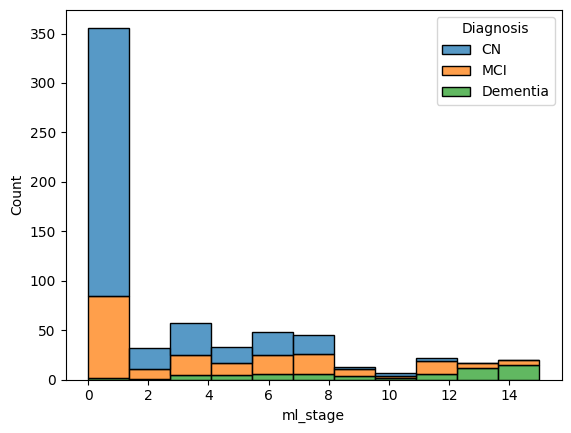

In [124]:
# Use clincial diagnostic categories as a rough way to assess the sucess of the model's stage assignments

#sns.displot(x='ml_stage',hue='Diagnosis',data=zdata)

sns.histplot(data=zdata, x='ml_stage', hue='Diagnosis', multiple='stack')
plt.show()